In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d harshwalia/birds-vs-drone-dataset

Dataset URL: https://www.kaggle.com/datasets/harshwalia/birds-vs-drone-dataset
License(s): unknown
 92% 72.0M/78.1M [00:00<00:00, 106MB/s]
100% 78.1M/78.1M [00:00<00:00, 103MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/birds-vs-drone-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import shutil
import random

# Define the source directories for birds and drones
birds_folder = '/content/BirdVsDrone/Birds'  # Update with your actual path
drones_folder = '/content/BirdVsDrone/Drones'  # Update with your actual path
test_folder = '/content/BirdVsDrone/testDF'  # Path where you want to create the test folder

# Create the test folder if it doesn't exist
os.makedirs(test_folder, exist_ok=True)

# Set the percentage of images for the test set (e.g., 15% or 20%)
percentage = 0.10 # Change this to 0.15 for 15%

# Function to select images and move them to the test folder
def select_images(source_folder, test_folder, num_images):
    all_images = [f for f in os.listdir(source_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(all_images, num_images)  # Randomly select images
    for filename in selected_images:
        source = os.path.join(source_folder, filename)
        destination = os.path.join(test_folder, filename)
        shutil.move(source, destination)  # Move selected images to test folder (removes from source)

# Select images from the birds folder
num_birds = int(len(os.listdir(birds_folder)) * percentage)
select_images(birds_folder, test_folder, num_birds)

# Select images from the drones folder
num_drones = int(len(os.listdir(drones_folder)) * percentage)
select_images(drones_folder, test_folder, num_drones)

print(f"Created a test set with {num_birds} birds and {num_drones} drones.")


Created a test set with 40 birds and 42 drones.


In [ ]:
import os

# Define the paths to your "Birds" and "Drones" folders
birds_folder = '/content/BirdVsDrone/Birds'
drones_folder = '/content/BirdVsDrone/Drones'

# Function to rename images in a folder with a specified prefix
def rename_images_in_folder(folder, prefix):
    files = os.listdir(folder)
    for index, filename in enumerate(files):
        # Check if the file is an image
        if filename.endswith((".jpg", ".jpeg", ".png",".JPG","JPEG","PNG","webp")):
            # Create the new filename with the given prefix and the index
            new_filename = f"{prefix}_{index+1}{os.path.splitext(filename)[1]}"

            # Get the full old and new file paths
            old_file = os.path.join(folder, filename)
            new_file = os.path.join(folder, new_filename)

            # Rename the file
            os.rename(old_file, new_file)

    print(f"Renaming complete for {prefix} folder!")

# Rename images in the "Birds" folder with the prefix "bird"
rename_images_in_folder(birds_folder, 'bird')

# Rename images in the "Drones" folder with the prefix "drone"
rename_images_in_folder(drones_folder, 'drone')


Renaming complete for bird folder!
Renaming complete for drone folder!


In [ ]:
import os
import shutil

# Define source folders
birds_folder = '/content/BirdVsDrone/Birds'
drones_folder = '/content/BirdVsDrone/Drones'

# Define destination folder
destination_folder = '/content/BirdVsDrone/MergeDataset'

# Create destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Function to copy files from a folder, skipping directories
def copy_files(source_folder, destination_folder):
    for filename in os.listdir(source_folder):
        source = os.path.join(source_folder, filename)
        destination = os.path.join(destination_folder, filename)
        # Check if it's a file before copying
        if os.path.isfile(source):
            shutil.copy(source, destination)

# Copy files from birds folder
copy_files(birds_folder, destination_folder)

# Copy files from drones folder
copy_files(drones_folder, destination_folder)

print("Files merged successfully!")


Files merged successfully!


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [ ]:
import os
import numpy as np
import pandas as pd

# Define the directory where your images are stored
data_dir = '/content/BirdVsDrone/MergeDataset'

# Extract image paths and labels
image_paths = []
labels = []

# Extract labels from filenames (assuming filenames contain 'bird' or 'drone')
for filename in os.listdir(data_dir):
    # Check for file extensions: .jpg, .jpeg, or .png
    if filename.endswith((".jpg", ".jpeg", ".png")):
        # Only add the image if the label is identifiable
        if "bird" in filename.lower():
            image_paths.append(os.path.join(data_dir, filename))
            labels.append("bird")  # Label for bird 0
        elif "drone" in filename.lower():
            image_paths.append(os.path.join(data_dir, filename))
            labels.append("drone")  # Label for drone 1

# Convert lists to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Create a DataFrame with paths and labels
df = pd.DataFrame({
    'filename': image_paths,
    'label': labels
})

# Display the first 5 rows of the DataFrame
df.head(5)


,filename,label
0,/content/BirdVsDrone/MergeDataset/drone_378.jpeg,drone
1,/content/BirdVsDrone/MergeDataset/bird_82.jpeg,bird
2,/content/BirdVsDrone/MergeDataset/bird_10.jpeg,bird
3,/content/BirdVsDrone/MergeDataset/bird_113.jpeg,bird
4,/content/BirdVsDrone/MergeDataset/bird_155.jpeg,bird


In [ ]:
df.shape

(476, 2)

In [ ]:
# Split the DataFrame into train, validation, and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)


In [ ]:
# Define ImageDataGenerator for augmenting training images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test data generators (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flow from DataFrame, using 'label' for class mode (for binary classification)
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=32
)
val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=32
)
test_generator = test_datagen.flow_from_dataframe(
    df_test,x_col='filename',
    y_col='label',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)




Found 304 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


In [ ]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # Binary classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


In [ ]:
# Train the model using the generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    steps_per_epoch=len(df_train) // 32,
    validation_steps=len(df_val) // 32
)


Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7095 - loss: 0.5973 - val_accuracy: 0.7344 - val_loss: 0.5743
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7812 - loss: 0.5238 - val_accuracy: 0.8333 - val_loss: 0.4786
Epoch 3/3


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7300 - loss: 0.5647 - val_accuracy: 0.7188 - val_loss: 0.5522


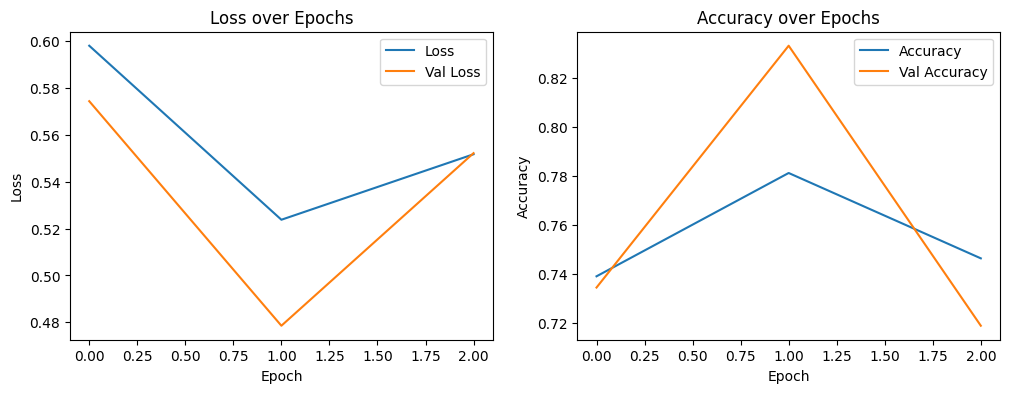

In [ ]:
# Plot the training and validation accuracy/loss
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()

plot_history(history)



In [ ]:
# Generate predictions on the test data
predictions = model.predict(test_generator, steps=len(test_generator))
# Calculate ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(df_test['label'].map({'bird': 0, 'drone': 1}), predictions)
roc_auc = auc(fpr, tpr)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


In [ ]:
thresholds

array([       inf, 0.34949747, 0.32949483, 0.31918162, 0.30972245,
       0.30878112, 0.28297827, 0.281339  , 0.2679026 , 0.262286  ,
       0.26172793, 0.26113367, 0.26000223, 0.25963083, 0.2588576 ,
       0.25867867, 0.25562263, 0.25432995, 0.25268462, 0.25028178,
       0.24837969, 0.24741177, 0.24602525, 0.2432171 , 0.23390052,
       0.23237763, 0.22584327, 0.2252632 , 0.19900559, 0.19662255,
       0.17469731, 0.17406023, 0.00616708], dtype=float32)

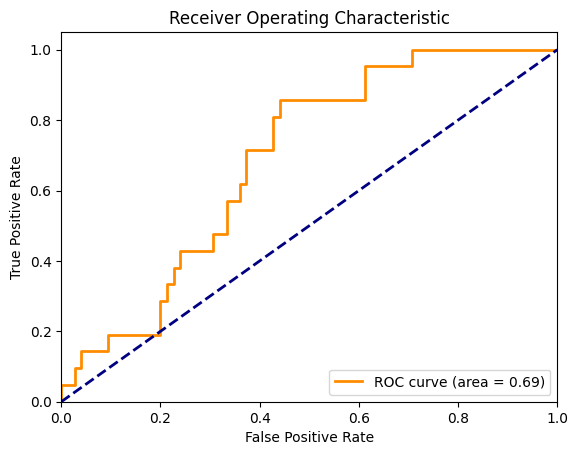

In [ ]:
# Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
# Find the best operating point (point closest to the top-left corner)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Best operating threshold: {optimal_threshold}")

# Apply the best threshold for classification
final_predictions = np.where(predictions >= optimal_threshold, 1, 0)

# Print the classification report
print(classification_report(df_test['label'].map({'bird': 0, 'drone': 1}), final_predictions))


Best operating threshold: 0.22526319324970245
              precision    recall  f1-score   support

           0       0.93      0.56      0.70        75
           1       0.35      0.86      0.50        21

    accuracy                           0.62        96
   macro avg       0.64      0.71      0.60        96
weighted avg       0.81      0.63      0.66        96



In [ ]:
import os
# Define the base path
base_path = '/content/BirdVsDrone/testDF'
# Get all file names including the base path
file_names = [os.path.join(base_path, file) for file in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, file))]
print(file_names[45])
print(file_names[25])


/content/BirdVsDrone/testDF/singleBirdinsky98.jpeg
/content/BirdVsDrone/testDF/singleDronesinsky6.jpeg


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab.patches import cv2_imshow

def predict_single_img(img_path, model, threshold=optimal_threshold):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(128, 128)) # Resize the image to the same size as training images
    img_array = image.img_to_array(img)
    cv2_imshow(img_array)

    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension (1, 128, 128, 3)
    img_array /= 255.0 # Rescale to match the scale of training data

    # Make a prediction
    prediction = model.predict(img_array)

    # Apply the threshold to make the final classification
    if prediction >= threshold:
      print(f"{img_path}: bird ({prediction[0][0]:.2f})")
    else:
      print(f"{img_path}: drone ({prediction[0][0]:.2f})")


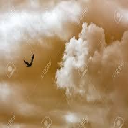

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
/content/BirdVsDrone/testDF/singleBirdinsky98.jpeg: bird (0.24)


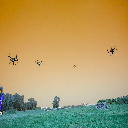

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
/content/BirdVsDrone/testDF/singleDronesinsky6.jpeg: drone (0.20)


In [ ]:
# Example usage
predict_single_img(file_names[45], model, threshold=optimal_threshold)
predict_single_img(file_names[25], model, threshold=optimal_threshold)